In [40]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad

import os.path as osp

In [2]:
SC_PTHS = dict(counts = "/home/alma/w-projects/help/franzi/data/sc/sc-liver-data-new.tsv.gz",
               meta = "/home/alma/w-projects/help/franzi/data/sc/sc-liver-meta-new2.tsv.gz")


In [3]:
cnt = pd.read_csv(SC_PTHS["counts"],
                  sep ="\t",
                   header = 0,
                   index_col = 0,
                  )

mta = pd.read_csv(SC_PTHS["meta"],
                   sep ="\t",
                   header = 0,
                   index_col = 0,
                  )

In [34]:
n_spots = 5000

n_genes = cnt.shape[1]
new_cnt = np.zeros((n_spots,n_genes))
uni_ct = np.unique(mta["bio_celltype"].values)
n_ct = len(uni_ct)
new_mem = np.zeros((n_spots,n_ct))
probs = np.ones(n_ct) / n_ct

umi_range = dict(low = 2000,
                 high = 10000,
                 )

idxs = [np.where(mta["bio_celltype"].values == ct)[0] for\
        ct in uni_ct]

for spot in range(n_spots):
    n_cells = 0
    while n_cells < 10:
        n_cells = int(round(np.random.normal(50,10)))
    
    n_members = np.random.multinomial(n_cells,probs)
    new_mem[spot,:] = n_members
    p_gene = np.zeros(n_genes)
    for k,m in enumerate(n_members):
        sel = np.random.choice(idxs[k],replace = True,size = m)
        p_gene += cnt.values[sel,:].sum(axis=0)
    p_gene = p_gene / p_gene.sum()
    n_umis = np.random.randint(umi_range["low"],umi_range["high"])
    new_cnt[spot,:] = np.random.multinomial(n_umis,p_gene)

In [36]:
obs = pd.DataFrame([f"Spot_{k}" for k in range(n_spots)],
                   index = [f"Spot_{k}" for k in range(n_spots)],
                   columns = ["spot"],
                  )

var = pd.DataFrame(cnt.columns.values,
                   index = cnt.columns,
                   columns = ["gene"],
                  )

new_cnt = ad.AnnData(new_cnt,
                     obs = obs,
                     var = var,
                    )
                    


In [37]:
new_cnt.obsm["true_cell_type_dist"] = pd.DataFrame(new_mem,
                                                   columns = uni_ct.tolist(),
                                                   index = obs.index,
                                                  )

In [39]:
new_cnt.obsm["true_cell_type_dist"]

,B cell_Fcmr high(Liver),B cell_Jchain high(Liver),Dendritic cell_Cst3 high(Liver),Dendritic cell_Siglech high(Liver),Endothelial cell(Liver),Epithelia cell_Spp1 high(Liver),Epithelial cell(Liver),Erythroblast_Hbb-bs high(Liver),Erythroblast_Hbb-bt high(Liver),Granulocyte(Liver),Hepatocyte_Fabp1 high(Liver),Hepatocyte_mt-Nd4 high(Liver),Kuppfer cell(Liver),Macrophage_Chil3 high(Liver),Neutrophil_Ngp high(Liver),Pericentral (PC) hepatocytes(Liver),Periportal (PP) hepatocyte(Liver),Stromal cell(Liver),T cell_Gzma high(Liver),T cell_Trbc2 high(Liver)
Spot_0,1.0,5.0,0.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.0,2.0,1.0,4.0,2.0,6.0,1.0,5.0,3.0,3.0
Spot_1,4.0,4.0,1.0,3.0,6.0,6.0,4.0,3.0,2.0,5.0,2.0,5.0,4.0,3.0,1.0,7.0,2.0,0.0,2.0,3.0
Spot_2,7.0,2.0,4.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,4.0,3.0,3.0,4.0,1.0,7.0,3.0
Spot_3,2.0,0.0,0.0,2.0,3.0,1.0,0.0,3.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,1.0,0.0,2.0,2.0,2.0
Spot_4,1.0,2.0,2.0,1.0,3.0,3.0,1.0,4.0,1.0,0.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,2.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Spot_4995,3.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,4.0,0.0,1.0,3.0,1.0,0.0,3.0,2.0,2.0,4.0,4.0
Spot_4996,4.0,2.0,4.0,2.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,3.0,2.0,4.0,0.0,4.0,1.0,1.0,1.0,0.0
Spot_4997,1.0,1.0,4.0,3.0,6.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,2.0,3.0,1.0,0.0,0.0,1.0,0.0
Spot_4998,0.0,0.0,2.0,3.0,1.0,1.0,3.0,5.0,1.0,2.0,1.0,2.0,2.0,4.0,4.0,1.0,4.0,0.0,2.0,2.0


In [41]:
new_cnt.write_h5ad("../data/synth/st/2021-07-20-synth-iter001.h5ad")

In [ ]:
%%bash
DPTH="../res/stereoscope-res"
ST_CNT_PTH="../data/synth/st/2021-07-20-synth-iter001.h5ad"
OPTH="res/stereoscope-res/synth/2021-07-20-synth-iter001/2021-07-20-synth-iter001"
stereoscope run --sc_fit $DPTH/R*.tsv $DPTH/logits*.tsv --st_cnt $ST_CNT_PTH/*h5ad -stb 2048 -ste 50000  -o $OPTH --gpu

## Analyze the data

In [179]:
CORR_PTHS = dict(obs = "/home/alma/w-projects/help/franzi/repo/res/stereoscope-res/corrs/all-corr-table.tsv",
                 syn= "/home/alma/w-projects/help/franzi/repo/res/stereoscope-res/synth/2021-07-20-synth-iter001/synth-corr-table.tsv",
                )


In [180]:
prp_obs = pd.read_csv(CORR_PTHS["obs"],sep="\t",header =0,index_col =0)
prp_syn = pd.read_csv(CORR_PTHS["syn"],sep="\t",header =0,index_col =0)
prp_syn = prp_syn[[x for x in prp_syn.columns if x.startswith("mean")]]
prp_obs = prp_obs[[x for x in prp_obs.columns if x.startswith("mean")]]

In [178]:
def reformat(s):
    return s.replace("mean.","").\
    replace(".Liver.","").\
    replace("..",".").\
    replace("._","_").\
    replace(".","_").\
    rstrip("high_").\
    replace("hepatocyte","hepa")

In [158]:

n = prp_obs.shape[0]
prp_obs_vec = np.zeros(int((n**2- n)/2))
prp_syn_vec = np.zeros(int((n**2- n)/2))
pairs = []
k = 0
for ii in range(n-1):
    for jj in range(ii+1,n):
        prp_obs_vec[k] = prp_obs.values[ii,jj]
        prp_syn_vec[k] = prp_syn.values[ii,jj]
        k += 1
        pairs.append(reformat(prp_syn.columns[ii]) + \
                      "_vs_" +\
                      reformat(prp_syn.columns[jj]))
        
pairs = np.array(pairs)

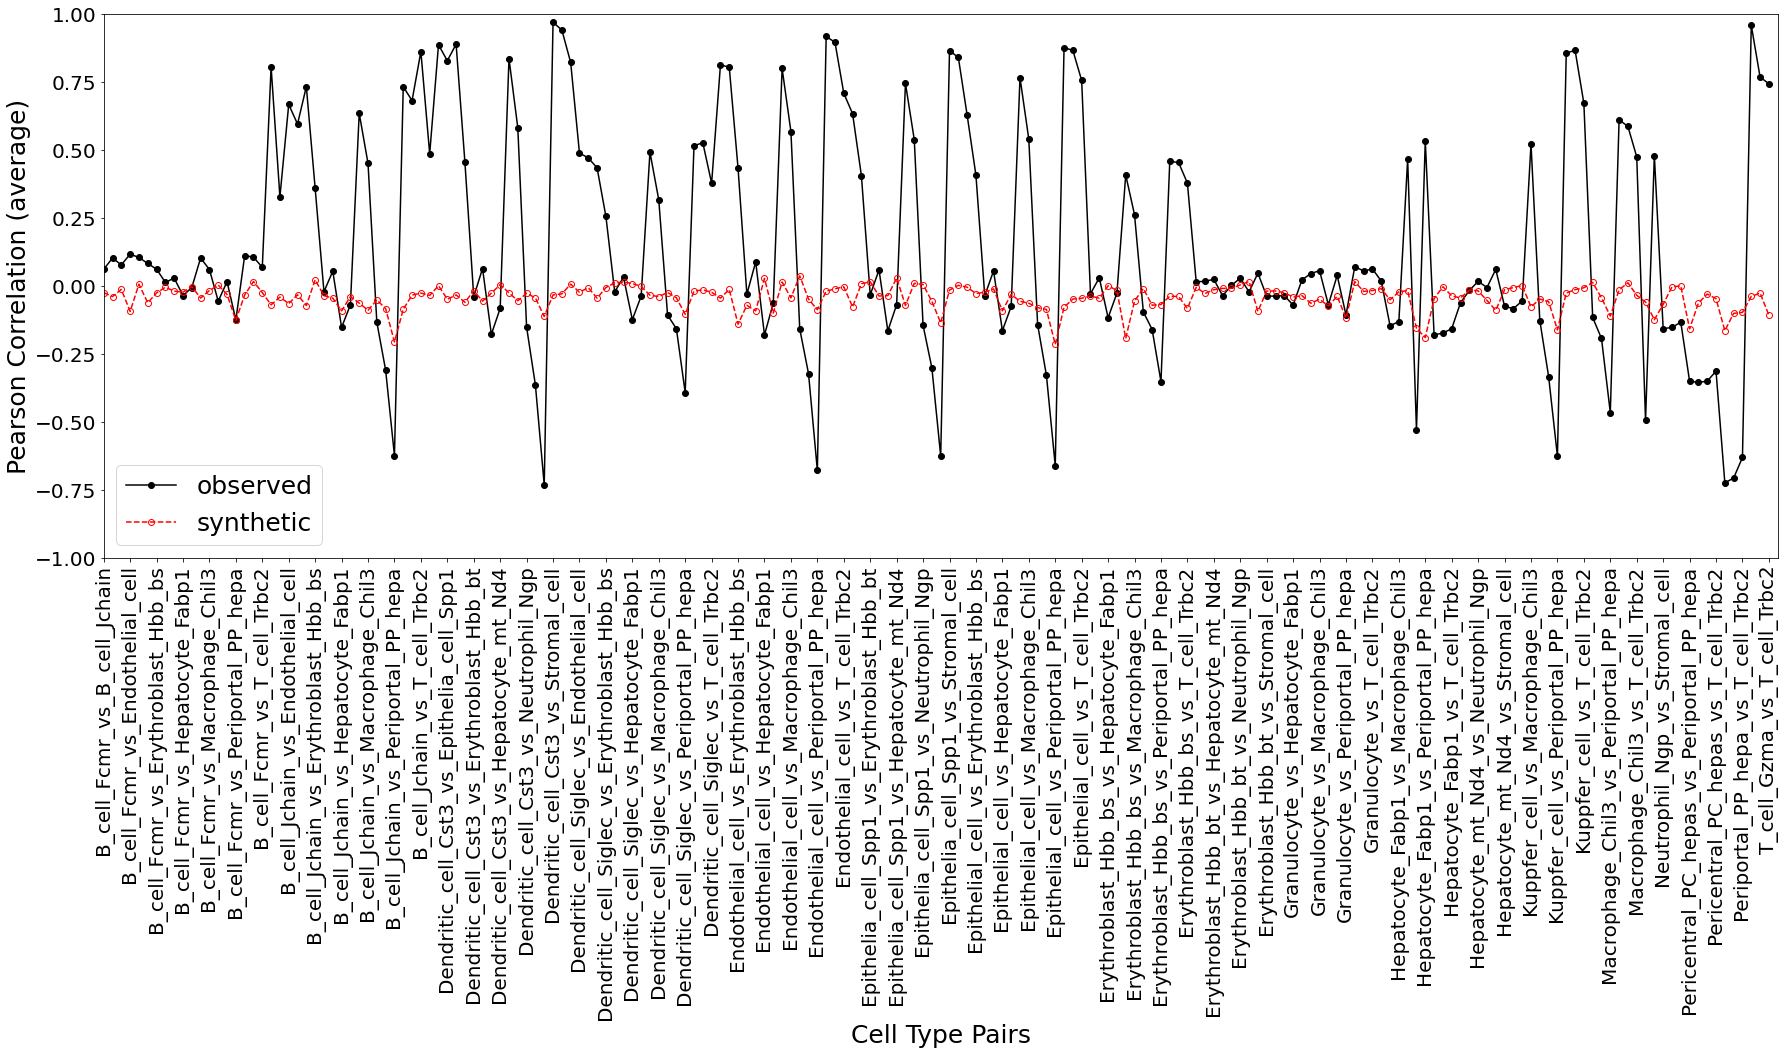

In [163]:
fig,ax = plt.subplots(figsize=(30,10))
ax.plot(prp_obs_vec,c = "black",label = "observed",marker = "o")
ax.plot(prp_syn_vec,c = "red", label = "synthetic",linestyle = "dashed",marker = "o",markerfacecolor = "none")
xticks = np.arange(0,k,3)
ax.set_xticks(xticks)
ax.set_xticklabels(pairs[xticks],rotation = 90)
ax.xaxis.set_tick_params(labelsize = 20)
ax.yaxis.set_tick_params(labelsize = 20)
ax.legend(fontsize = 25)
ax.set_ylim([-1,1])
ax.set_xlim([0,k])
ax.set_xlabel("Cell Type Pairs",fontsize = 25)
ax.set_ylabel("Pearson Correlation (average)",fontsize = 25)
plt.show()